<center>
<h1>Assignment #2 for Clustering: Sessa Empirical Estimator (SEE)</h1>
by Christian Abay-abay & Thristan Jay Nakila
</center>

### Instructions
1. **Read the Journals about the Sessa Empirical Estimator**
   - *Refer to:* `/journals`
2. **Convert the R codes into Python**
   - **R codes:** `SEE.R`
   - **Python conversion:** `SEE.ipynb`
3. **Perform the Sessa Empirical Estimator**
   - Use either simulated data or real-world datasets of your choice.
   - Generate insights based on the estimator's results.
4. **Experiment with clustering algorithms**
   - The estimator uses K-means by default. Try substituting it with a different clustering algorithm to derive new insights.
   - *Note:* K-means has its disadvantages.
5. **Compare the results**
   - Analyze and compare the outcomes between the estimator using K-means and the one using your chosen clustering algorithm.
6. **Develop callable functions**
   - Create a callable function for each step.
   - Verify that these functions produce the same results (and insights) as observed in your Jupyter Notebook.
7. **Collaborate with your thesis partner**

**Deadline:** Feb 25, 2025 at 11:59PM


***
<center>
<h2>Data Set Used</h2>
CSV file was extracted from `SEE.R`. File is found in `data/med-events.csv`. Special thank you to Ian S. for guiding us through this process.
</center>

***
<center>
<h2>SEE.R Conversion to Python Code</h2>
Since SEE.R is in a different language, we had two options to make use of its content. (1) Make use of the rpy2 library or (2) Convert the whole SEE.R into Python. We opted for the latter option as it would make it easier for us to debug and make further references of the code in the later stages of the notebook.
</center>

Data loaded with shape: (1080, 5)
   pnr       eksd  perday   ATC  dur_original
0    1 2033-04-26       4  medA            50
1    1 2033-07-04       4  medB            30
2    1 2033-08-03       4  medB            30
3    1 2033-08-17       4  medB            30
4    1 2033-10-13       4  medB            30


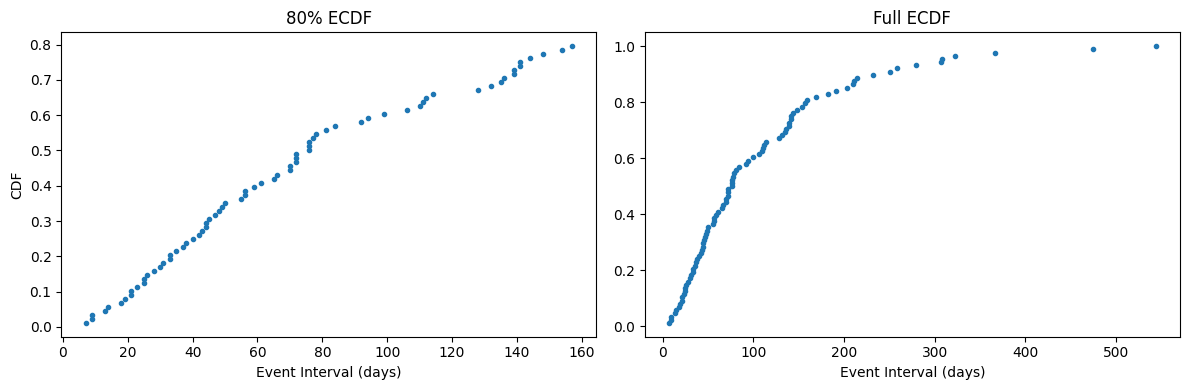

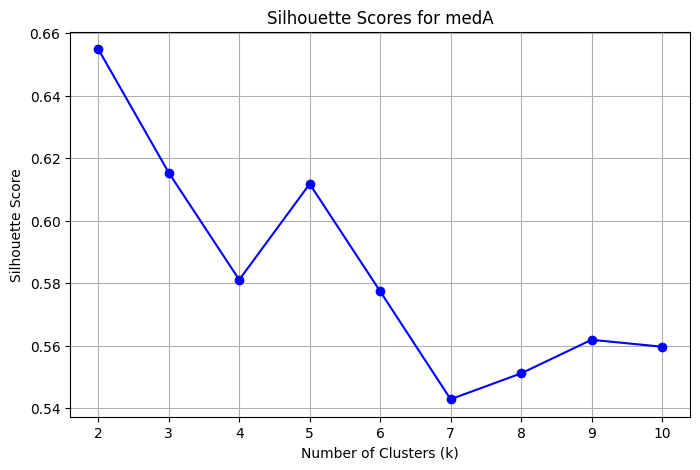

Optimal number of clusters (silhouette): 2
Cluster summary statistics:
   Cluster  Minimum  Maximum  Median
0        0       92      157   133.5
1        1        7       84    44.0


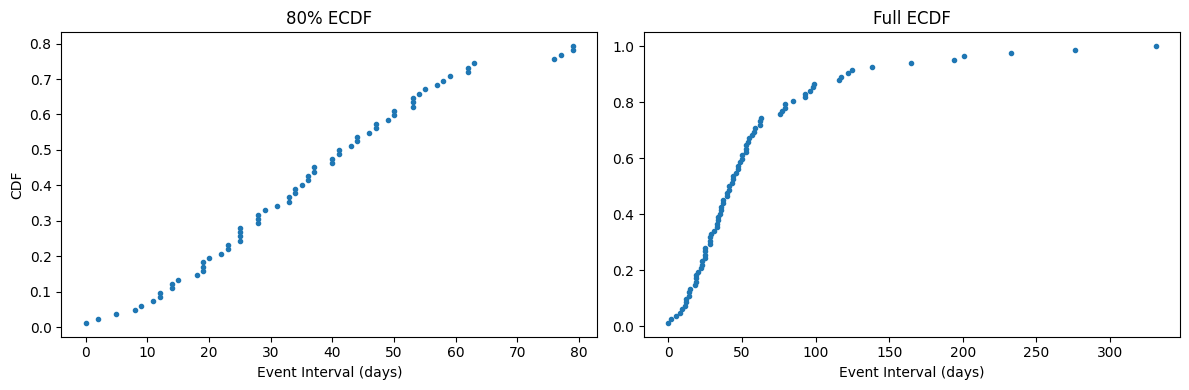

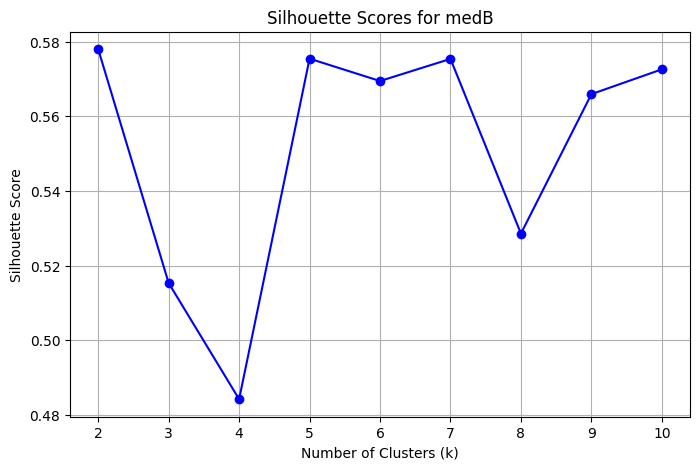

Optimal number of clusters (silhouette): 2
Cluster summary statistics:
   Cluster  Minimum  Maximum  Median
0        0       40       79    53.0
1        1        2       37    24.0


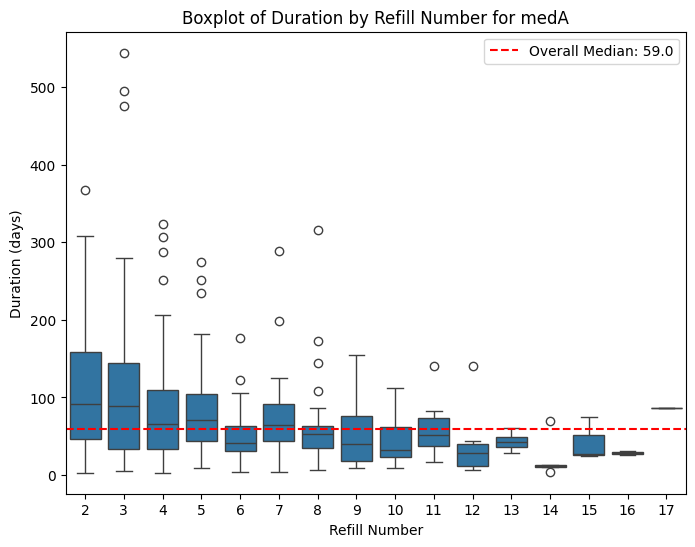

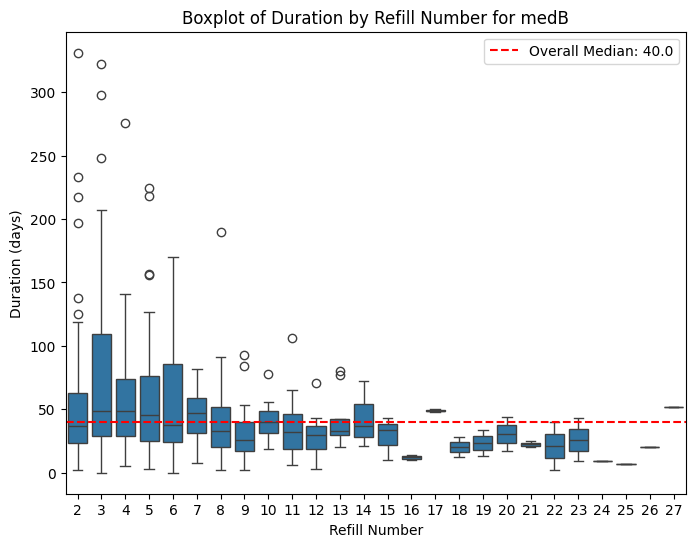

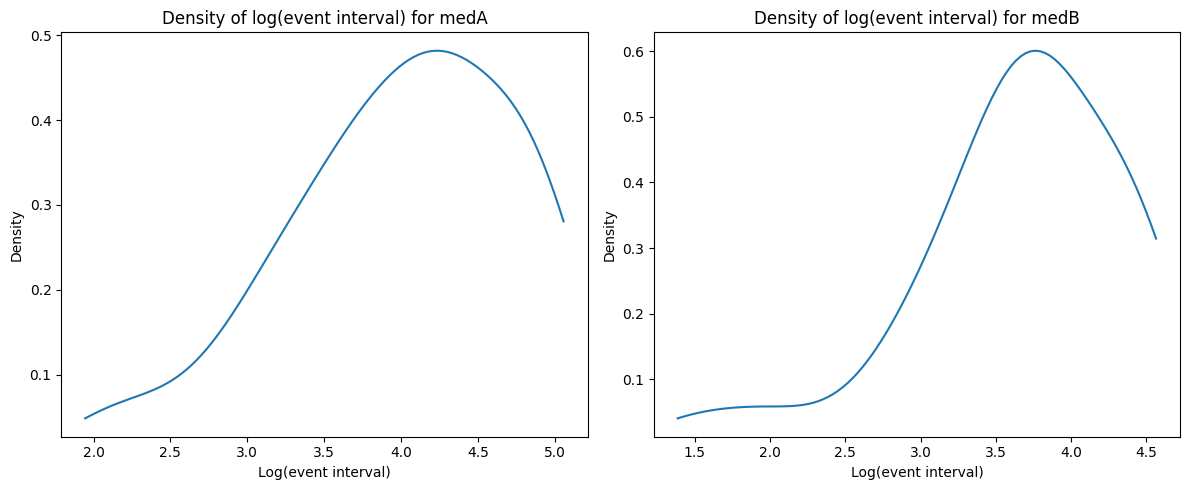

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
random.seed(1234)  # Set random seed for random sampling
np.random.seed(1234)  # Set random seed for numpy operations


# -------------------------------
# Data Preparation
# -------------------------------
tidy = pd.read_csv("data/med-events.csv", sep="\t")
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format="%m/%d/%Y", errors='coerce')
print("Data loaded with shape:", tidy.shape)
print(tidy.head())

# -------------------------------
# Function: See
# -------------------------------
def See(drug, df):
    """
    Processes data for a given drug by:
      - Filtering by drug (ATC code)
      - Computing previous prescription dates and event intervals
      - Building the ECDF and filtering to the lower 80% to remove outliers
      - Clustering the filtered data and assigning an estimated median duration from clusters back to each patient
    Note: The density plot is now removed from this function.
    """
    # 1. Filter for the desired drug
    subset = df[df['ATC'] == drug].copy()
    Drug_see_p0 = subset.copy()
    
    # 2. Compute previous prescription date per patient
    df_work = subset.sort_values(['pnr', 'eksd']).copy()
    df_work['prev_eksd'] = df_work.groupby('pnr')['eksd'].shift(1)
    df_work = df_work.dropna(subset=['prev_eksd'])
    
    # 3. Randomly sample one event per patient using built-in groupby sample
    random.seed(1234)  # Set random seed for sampling
    df_sampled = df_work.groupby('pnr', group_keys=False).sample(n=1, random_state=1234).reset_index(drop=True)
    df_sampled = df_sampled[['pnr', 'eksd', 'prev_eksd']].copy()

    # 4. Compute event interval (days)
    df_sampled['event_interval'] = (df_sampled['eksd'] - df_sampled['prev_eksd']).dt.days
    
    # 5. Compute the ECDF for event_interval
    intervals = np.sort(df_sampled['event_interval'].values)
    cdf = np.arange(1, len(intervals) + 1) / len(intervals)
    df_ecdf = pd.DataFrame({'x': intervals, 'cdf': cdf})
    
    # 6. Retain lower 80% of ECDF to remove outliers
    df_ecdf_80 = df_ecdf[df_ecdf['cdf'] <= 0.8]
    ni = df_ecdf_80['x'].max()  # cutoff threshold

    # Plot ECDFs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf_80['x'], df_ecdf_80['cdf'], marker='.', linestyle='none')
    plt.title("80% ECDF")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("CDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(df_ecdf['x'], df_ecdf['cdf'], marker='.', linestyle='none')
    plt.title("Full ECDF")
    plt.xlabel("Event Interval (days)")
    plt.tight_layout()
    plt.show()
    # 7. Filter sampled data to intervals <= cutoff (lower 80%)
    df_filtered = df_sampled[df_sampled['event_interval'] <= ni].copy()
    
    # Remove zero or negative intervals to avoid log issues
    df_filtered = df_filtered[df_filtered['event_interval'] > 0].copy()
    
    # If no valid intervals remain, handle gracefully
    if df_filtered.empty:
        print(f"No valid positive event intervals for drug {drug} after filtering.")
        return subset  # or return an empty DataFrame if preferred
    
    # 8. Clustering on filtered data (density estimation removed)
    scaler = StandardScaler()
    X = scaler.fit_transform(df_filtered[['event_interval']])
    sil_scores = {}
    max_clusters = 10  # Change this number to set your desired maximum
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=1234)  
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        sil_scores[k] = score

    plot_silhouette_scores(sil_scores, drug)
    optimal_k = max(sil_scores, key=sil_scores.get)
    print("Optimal number of clusters (silhouette):", optimal_k)
    
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=1234) 
    df_filtered['Cluster'] = kmeans_final.fit_predict(X)
    
    # 9. Compute cluster summary statistics on original event_interval values
    cluster_stats = df_filtered.groupby('Cluster')['event_interval'].agg(['min', 'max', 'median']).reset_index()
    cluster_stats = cluster_stats.rename(columns={'min': 'Minimum', 'max': 'Maximum', 'median': 'Median'})
    print("Cluster summary statistics:")
    print(cluster_stats)
    
    # 10. Assign each patient's event_interval an estimated duration based on clusters
    def assign_cluster(interval):
        for idx, row in cluster_stats.iterrows():
            if row['Minimum'] <= interval <= row['Maximum']:
                return row['Median'], row['Cluster']
        # Fallback: use median from the most common cluster if no match
        most_common_cluster = cluster_stats['Cluster'].value_counts().idxmax()
        median_val = cluster_stats.loc[cluster_stats['Cluster'] == most_common_cluster, 'Median'].values[0]
        return median_val, most_common_cluster

    df_sampled[['Assigned_Median', 'Assigned_Cluster']] = df_sampled['event_interval'].apply(
        lambda x: pd.Series(assign_cluster(x))
    )
    df_sampled['test'] = np.round(df_sampled['event_interval'] - df_sampled['Assigned_Median'], 1)
    
    # 11. Merge the assigned values back to the original drug subset
    Drug_see_p3 = df_sampled[['pnr', 'Assigned_Median', 'Assigned_Cluster']].copy()
    final_result = Drug_see_p0.merge(Drug_see_p3, on='pnr', how='left')
    final_result['Assigned_Median'] = pd.to_numeric(final_result['Assigned_Median'], errors='coerce')
    most_common_cluster = cluster_stats['Cluster'].value_counts().idxmax()
    fallback_median = cluster_stats.loc[cluster_stats['Cluster'] == most_common_cluster, 'Median'].values[0]
    final_result['Assigned_Median'] = final_result['Assigned_Median'].fillna(fallback_median)
    final_result['Assigned_Cluster'] = final_result['Assigned_Cluster'].fillna(0).astype(int)
    
    return final_result

# -------------------------------
# Function: see_assumption
# -------------------------------
def see_assumption(df, drug_label):
    """
    Visualizes refill durations by plotting them against the refill number.
    The title includes the provided drug_label for clarity.
    """
    df_assump = df.sort_values(['pnr', 'eksd']).copy()
    df_assump['prev_eksd'] = df_assump.groupby('pnr')['eksd'].shift(1)
    df_assump['p_number'] = df_assump.groupby('pnr').cumcount() + 1
    df_assump = df_assump[df_assump['p_number'] >= 2].copy()
    df_assump = df_assump[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    df_assump['Duration'] = (df_assump['eksd'] - df_assump['prev_eksd']).dt.days
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_assump)
    plt.title(f"Boxplot of Duration by Refill Number for {drug_label}")
    plt.xlabel("Refill Number")
    plt.ylabel("Duration (days)")
    overall_median = df_assump['Duration'].median()
    plt.axhline(y=overall_median, color='red', linestyle='--',
                label=f'Overall Median: {overall_median:.1f}')
    plt.legend()
    plt.show()

    

# -------------------------------
# New Helper Functions for Density Plots
# -------------------------------
def compute_log_density(drug, df):
    """
    Computes the density of the log-transformed event intervals for a given drug.
    Returns x and y arrays for plotting the density curve.
    """
    # Filter for the drug and compute previous prescription dates
    subset = df[df['ATC'] == drug].copy()
    df_work = subset.sort_values(['pnr', 'eksd']).copy()
    df_work['prev_eksd'] = df_work.groupby('pnr')['eksd'].shift(1)
    df_work = df_work.dropna(subset=['prev_eksd'])
    
    # Sample one event per patient
    df_sampled = df_work.groupby('pnr', group_keys=False).sample(n=1).reset_index(drop=True)
    df_sampled['event_interval'] = (df_sampled['eksd'] - df_sampled['prev_eksd']).dt.days
    
    # Compute ECDF and define cutoff (80%)
    intervals = np.sort(df_sampled['event_interval'].values)
    cdf = np.arange(1, len(intervals) + 1) / len(intervals)
    df_ecdf = pd.DataFrame({'x': intervals, 'cdf': cdf})
    df_ecdf_80 = df_ecdf[df_ecdf['cdf'] <= 0.8]
    ni = df_ecdf_80['x'].max()
    
    # Filter data to intervals within cutoff and positive intervals only
    df_filtered = df_sampled[df_sampled['event_interval'] <= ni].copy()
    df_filtered = df_filtered[df_filtered['event_interval'] > 0].copy()
    
    if df_filtered.empty:
        return None, None
    
    # Compute density of log-transformed intervals
    log_intervals = np.log(df_filtered['event_interval'])
    kde = gaussian_kde(log_intervals)
    x_dens = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_dens = kde(x_dens)
    return x_dens, y_dens

def plot_density_side_by_side(df, drugs):
    """
    Plots the density of log(event interval) for each drug in the list `drugs` side by side.
    """
    n = len(drugs)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    if n == 1:
        axes = [axes]
    for i, drug in enumerate(drugs):
        x, y = compute_log_density(drug, df)
        if x is None:
            axes[i].set_title(f"No valid density for {drug}")
        else:
            axes[i].plot(x, y)
            axes[i].set_title(f"Density of log(event interval) for {drug}")
            axes[i].set_xlabel("Log(event interval)")
            axes[i].set_ylabel("Density")
    plt.tight_layout()
    plt.show()
    

    plt.show()

def plot_silhouette_scores(sil_scores, drug_name):
    """
    Plots silhouette scores for different numbers of clusters for a single drug.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o', linestyle='-', color='b')
    plt.title(f"Silhouette Scores for {drug_name}")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()
# -------------------------------
# Example usage:
# -------------------------------
medA = See("medA", tidy)
medB = See("medB", tidy)

see_assumption(medA, "medA")
see_assumption(medB, "medB")

# Plot density of log(event interval) for medA and medB side by side
plot_density_side_by_side(tidy, ["medA", "medB"])


***
<center>
    <h2>Use of DBScan instead of K-Means</h2>
    K-Means has a couple of disadvantages that come with it. One of which being that we have to specify 'K'(number of clusters) in advanced.
    This can be a problem in real-world cases since the optimal number of clusters is not usually known prior to running the algorithm. DBScan solves this since there is no need to specify 'K', and will automatically find the number of clusters based on the data's density. In this section, try to implement the Sessa Empirical Estimator (SEE), but with the use of DBScan instead of K-Means for the clustering algorithm.
</center>

Data loaded with shape: (1080, 5)
   pnr       eksd  perday   ATC  dur_original
0    1 2033-04-26       4  medA            50
1    1 2033-07-04       4  medB            30
2    1 2033-08-03       4  medB            30
3    1 2033-08-17       4  medB            30
4    1 2033-10-13       4  medB            30


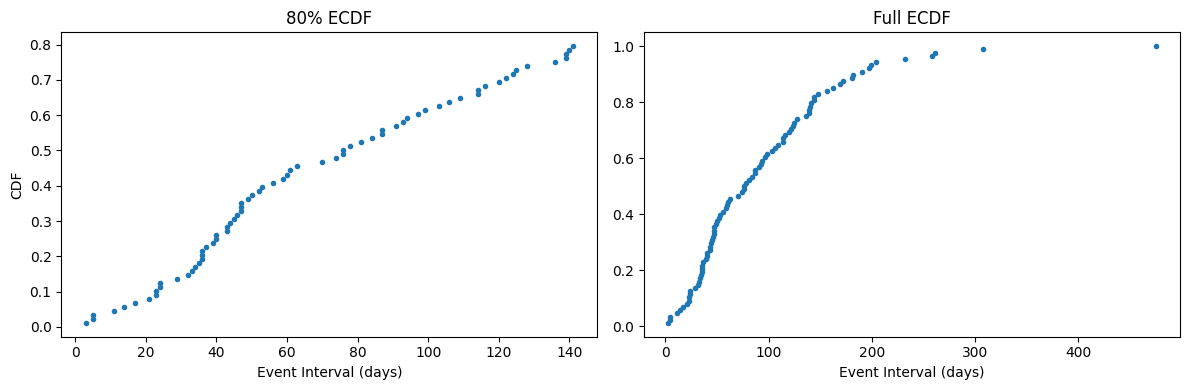

DBSCAN cluster labels (including noise labeled as -1): [0]
Not enough valid clusters to calculate silhouette score.
Cluster summary statistics:
   Cluster  Minimum  Maximum  Median
0        0        3      141    54.5


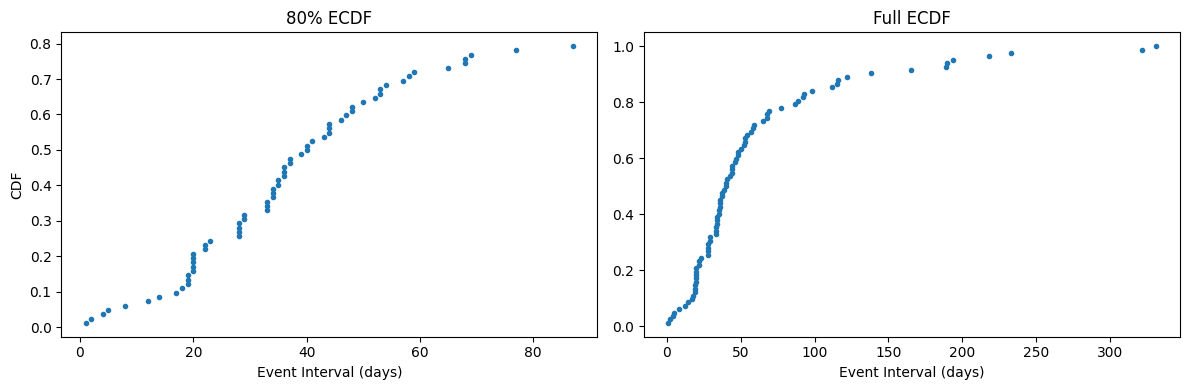

DBSCAN cluster labels (including noise labeled as -1): [-1  0  1]
Silhouette Score for DBSCAN clustering: 0.4678


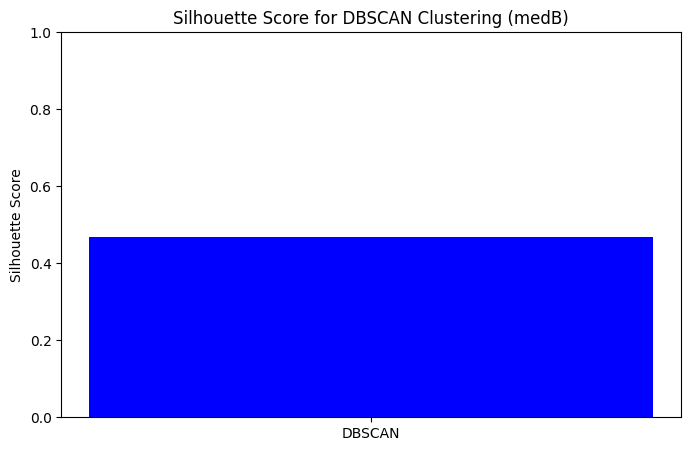

Cluster summary statistics:
   Cluster  Minimum  Maximum  Median
0        0       12       59    34.5
1        1        1        8     4.0


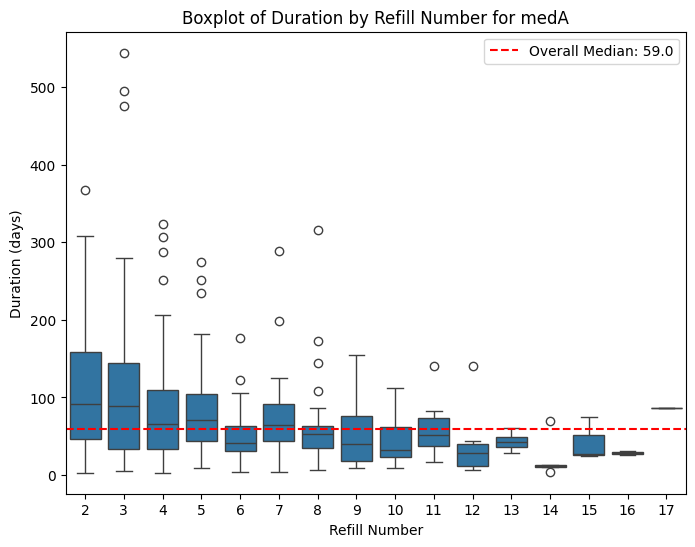

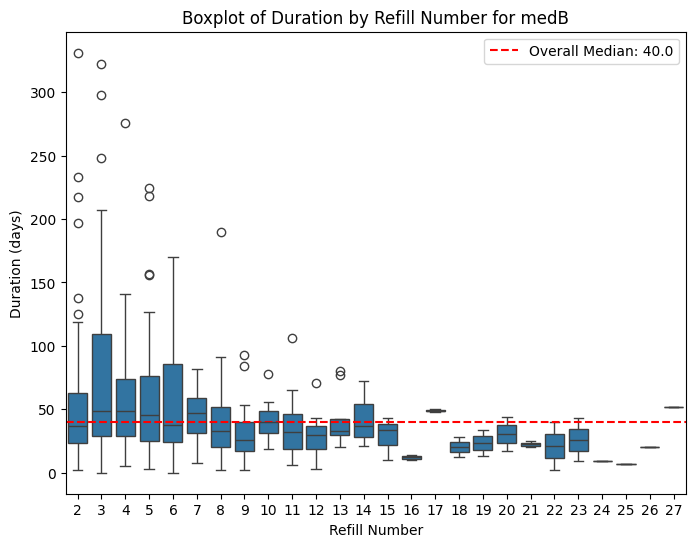

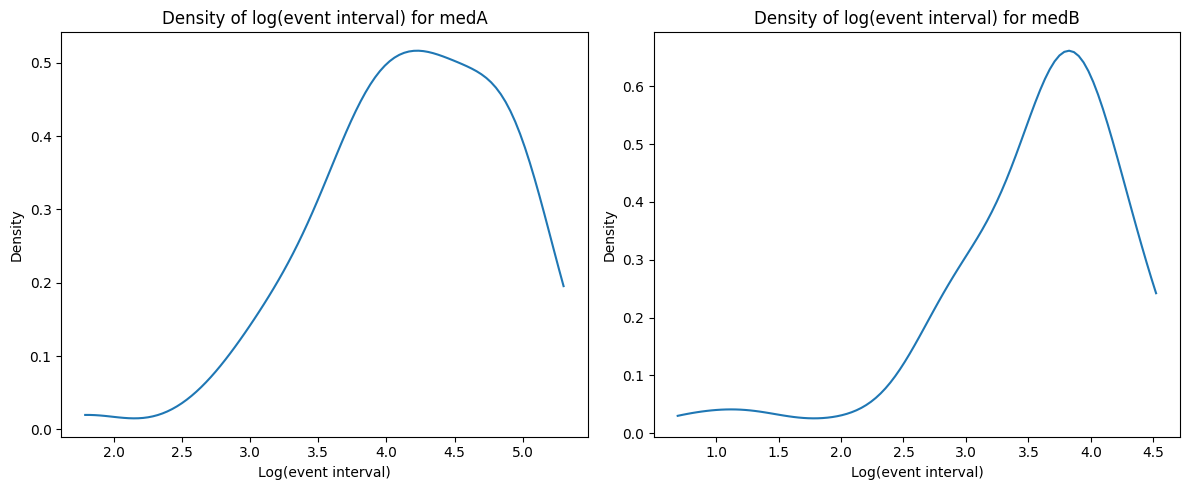

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import silhouette_score  # no longer used for clustering
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN

# -------------------------------
# Data Preparation (same as before)
# -------------------------------
tidy = pd.read_csv("data/med-events.csv", sep="\t")
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format="%m/%d/%Y", errors='coerce')
print("Data loaded with shape:", tidy.shape)
print(tidy.head())

# -------------------------------
# Function: See (using DBSCAN)
# -------------------------------
def See(drug, df, eps=0.3, min_samples=5):
    """
    Processes data for a given drug by:
      - Filtering by drug (ATC code)
      - Computing previous prescription dates and event intervals
      - Building the ECDF and filtering to the lower 80% to remove outliers
      - Clustering the filtered data using DBSCAN and assigning an estimated median duration
        from clusters back to each patient.
    """
    # 1. Filter for the desired drug
    subset = df[df['ATC'] == drug].copy()
    Drug_see_p0 = subset.copy()
    
    # 2. Compute previous prescription date per patient
    df_work = subset.sort_values(['pnr', 'eksd']).copy()
    df_work['prev_eksd'] = df_work.groupby('pnr')['eksd'].shift(1)
    df_work = df_work.dropna(subset=['prev_eksd'])
    
    # 3. Randomly sample one event per patient using built-in groupby sample
    df_sampled = df_work.groupby('pnr', group_keys=False).sample(n=1).reset_index(drop=True)
    df_sampled = df_sampled[['pnr', 'eksd', 'prev_eksd']].copy()
    
    # 4. Compute event interval (days)
    df_sampled['event_interval'] = (df_sampled['eksd'] - df_sampled['prev_eksd']).dt.days
    
    # 5. Compute the ECDF for event_interval
    intervals = np.sort(df_sampled['event_interval'].values)
    cdf = np.arange(1, len(intervals) + 1) / len(intervals)
    df_ecdf = pd.DataFrame({'x': intervals, 'cdf': cdf})
    
    # 6. Retain lower 80% of ECDF to remove outliers
    df_ecdf_80 = df_ecdf[df_ecdf['cdf'] <= 0.8]
    ni = df_ecdf_80['x'].max()  # cutoff threshold
    
    # Plot ECDFs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf_80['x'], df_ecdf_80['cdf'], marker='.', linestyle='none')
    plt.title("80% ECDF")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("CDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(df_ecdf['x'], df_ecdf['cdf'], marker='.', linestyle='none')
    plt.title("Full ECDF")
    plt.xlabel("Event Interval (days)")
    plt.tight_layout()
    plt.show()
    
    # 7. Filter sampled data to intervals <= cutoff (lower 80%)
    df_filtered = df_sampled[df_sampled['event_interval'] <= ni].copy()
    df_filtered = df_filtered[df_filtered['event_interval'] > 0].copy()  # remove zero/negative intervals
    
    if df_filtered.empty:
        print(f"No valid positive event intervals for drug {drug} after filtering.")
        return subset
    
    # 8. Clustering on filtered data using DBSCAN
    scaler = StandardScaler()
    X = scaler.fit_transform(df_filtered[['event_interval']])
    # Note: eps and min_samples may need tuning based on the data
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X)
    df_filtered['Cluster'] = dbscan_labels
    print("DBSCAN cluster labels (including noise labeled as -1):", np.unique(dbscan_labels))

    valid_clusters = df_filtered[df_filtered['Cluster'] != -1]
    if len(np.unique(valid_clusters['Cluster'])) > 1:  # At least 2 clusters needed for silhouette score
        silhouette_avg = silhouette_score(X[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
        print(f"Silhouette Score for DBSCAN clustering: {silhouette_avg:.4f}")
        
        # Plot silhouette score
        plt.figure(figsize=(8, 5))
        plt.bar(['DBSCAN'], [silhouette_avg], color='blue')
        plt.title(f"Silhouette Score for DBSCAN Clustering ({drug})")
        plt.ylabel("Silhouette Score")
        plt.ylim(0, 1)  # Silhouette score ranges from -1 to 1
        plt.show()
    else:
        print("Not enough valid clusters to calculate silhouette score.")
    
    # 9. Compute cluster summary statistics on original event_interval values,
    #    excluding noise (cluster label -1)
    valid_clusters = df_filtered[df_filtered['Cluster'] != -1]
    if valid_clusters.empty:
        print("DBSCAN did not find any clusters. Falling back to default median.")
        default_median = df_filtered['event_interval'].median()
        df_sampled['Assigned_Median'] = default_median
        df_sampled['Assigned_Cluster'] = -1
    else:
        cluster_stats = valid_clusters.groupby('Cluster')['event_interval'].agg(['min', 'max', 'median']).reset_index()
        cluster_stats = cluster_stats.rename(columns={'min': 'Minimum', 'max': 'Maximum', 'median': 'Median'})
        print("Cluster summary statistics:")
        print(cluster_stats)
    
        # 10. Assign each patient's event_interval an estimated duration based on clusters
        def assign_cluster(interval):
            for idx, row in cluster_stats.iterrows():
                if row['Minimum'] <= interval <= row['Maximum']:
                    return row['Median'], row['Cluster']
            # Fallback: use median from the most common cluster if no match
            most_common_cluster = cluster_stats['Cluster'].value_counts().idxmax()
            median_val = cluster_stats.loc[cluster_stats['Cluster'] == most_common_cluster, 'Median'].values[0]
            return median_val, most_common_cluster

        df_sampled[['Assigned_Median', 'Assigned_Cluster']] = df_sampled['event_interval'].apply(
            lambda x: pd.Series(assign_cluster(x))
        )
        df_sampled['test'] = np.round(df_sampled['event_interval'] - df_sampled['Assigned_Median'], 1)
    
    # 11. Merge the assigned values back to the original drug subset
    Drug_see_p3 = df_sampled[['pnr', 'Assigned_Median', 'Assigned_Cluster']].copy()
    final_result = Drug_see_p0.merge(Drug_see_p3, on='pnr', how='left')
    final_result['Assigned_Median'] = pd.to_numeric(final_result['Assigned_Median'], errors='coerce')
    
    # If any patients are missing an assignment, fill with fallback values
    if 'Assigned_Cluster' in final_result.columns:
        most_common_cluster = (cluster_stats['Cluster'].value_counts().idxmax() 
                               if not valid_clusters.empty else 0)
        fallback_median = (cluster_stats.loc[cluster_stats['Cluster'] == most_common_cluster, 'Median'].values[0] 
                           if not valid_clusters.empty else final_result['event_interval'].median())
        final_result['Assigned_Median'] = final_result['Assigned_Median'].fillna(fallback_median)
        final_result['Assigned_Cluster'] = final_result['Assigned_Cluster'].fillna(0).astype(int)
    
    return final_result

# -------------------------------
# Function: see_assumption (same as before)
# -------------------------------
def see_assumption(df, drug_label):
    """
    Visualizes refill durations by plotting them against the refill number.
    The title includes the provided drug_label for clarity.
    """
    df_assump = df.sort_values(['pnr', 'eksd']).copy()
    df_assump['prev_eksd'] = df_assump.groupby('pnr')['eksd'].shift(1)
    df_assump['p_number'] = df_assump.groupby('pnr').cumcount() + 1
    df_assump = df_assump[df_assump['p_number'] >= 2].copy()
    df_assump = df_assump[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    df_assump['Duration'] = (df_assump['eksd'] - df_assump['prev_eksd']).dt.days
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_assump)
    plt.title(f"Boxplot of Duration by Refill Number for {drug_label}")
    plt.xlabel("Refill Number")
    plt.ylabel("Duration (days)")
    overall_median = df_assump['Duration'].median()
    plt.axhline(y=overall_median, color='red', linestyle='--',
                label=f'Overall Median: {overall_median:.1f}')
    plt.legend()
    plt.show()

# -------------------------------
# New Helper Functions for Density Plots (same as before)
# -------------------------------
def compute_log_density(drug, df):
    subset = df[df['ATC'] == drug].copy()
    df_work = subset.sort_values(['pnr', 'eksd']).copy()
    df_work['prev_eksd'] = df_work.groupby('pnr')['eksd'].shift(1)
    df_work = df_work.dropna(subset=['prev_eksd'])
    df_sampled = df_work.groupby('pnr', group_keys=False).sample(n=1).reset_index(drop=True)
    df_sampled['event_interval'] = (df_sampled['eksd'] - df_sampled['prev_eksd']).dt.days
    intervals = np.sort(df_sampled['event_interval'].values)
    cdf = np.arange(1, len(intervals) + 1) / len(intervals)
    df_ecdf = pd.DataFrame({'x': intervals, 'cdf': cdf})
    df_ecdf_80 = df_ecdf[df_ecdf['cdf'] <= 0.8]
    ni = df_ecdf_80['x'].max()
    df_filtered = df_sampled[df_sampled['event_interval'] <= ni].copy()
    df_filtered = df_filtered[df_filtered['event_interval'] > 0].copy()
    
    if df_filtered.empty:
        return None, None
    
    log_intervals = np.log(df_filtered['event_interval'])
    kde = gaussian_kde(log_intervals)
    x_dens = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_dens = kde(x_dens)
    return x_dens, y_dens

def plot_density_side_by_side(df, drugs):
    n = len(drugs)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    if n == 1:
        axes = [axes]
    for i, drug in enumerate(drugs):
        x, y = compute_log_density(drug, df)
        if x is None:
            axes[i].set_title(f"No valid density for {drug}")
        else:
            axes[i].plot(x, y)
            axes[i].set_title(f"Density of log(event interval) for {drug}")
            axes[i].set_xlabel("Log(event interval)")
            axes[i].set_ylabel("Density")
    plt.tight_layout()
    plt.show()

# -------------------------------
# Example usage:
# -------------------------------
medA = See("medA", tidy)
medB = See("medB", tidy)

see_assumption(medA, "medA")
see_assumption(medB, "medB")

# Plot density of log(event interval) for medA and medB side by side
plot_density_side_by_side(tidy, ["medA", "medB"])

***
<center>
    <h2>Insights</h2>
    <h3>K-Means vs DBScan</h3>
</center>